In [3]:
import pyspark
sc = pyspark.SparkContext('local[*]')

# do something to prove it works
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)

[988, 619, 139, 10, 755]

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

print('Modules are imported.')

Modules are imported.


In [5]:
# Initialize Spark session
spark = SparkSession.builder.appName("Covid19Analysis").getOrCreate()

In [6]:
covid_data = spark.read.csv('covid-19.csv', header=True, inferSchema=True)

In [7]:
# Perform necessary data transformations
covid_data = covid_data.withColumn("date", F.to_date("date", "yyyy-MM-dd"))

In [8]:
windowSpec = Window.orderBy("date")

covid_data = covid_data.withColumn("daily_confirmed", F.col("confirmed") - F.lag("confirmed").over(windowSpec))
covid_data = covid_data.withColumn("daily_confirmed", F.when(F.isnull("daily_confirmed"), 0).otherwise(F.col("daily_confirmed")))

# Use cumulative sum to get total confirmed cases over time
covid_data = covid_data.withColumn("total_confirmed", F.sum("daily_confirmed").over(windowSpec))

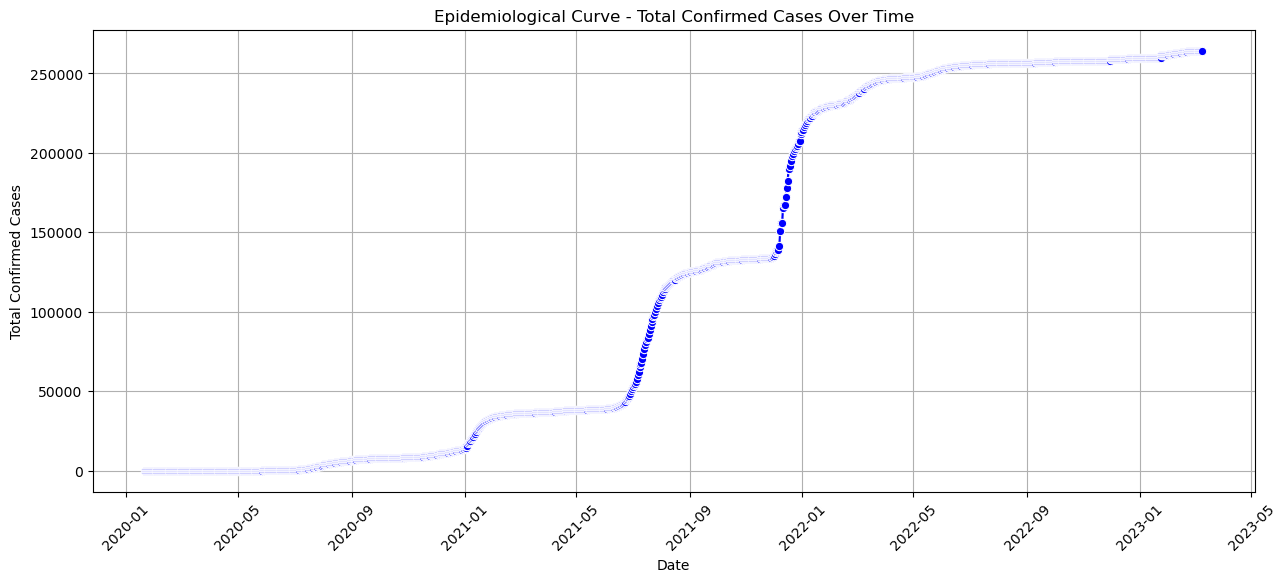

In [9]:
# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = covid_data.select("date", "total_confirmed").toPandas()

# Visualize total confirmed cases over time
plt.figure(figsize=(15, 6))
sns.lineplot(x="date", y="total_confirmed", data=pandas_df, marker='o', color='blue')
plt.title('Epidemiological Curve - Total Confirmed Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Confirmed Cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [10]:
# Stop the Spark session
spark.stop()